# Reliability anaysis


## Packages and Helpers

In [1]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

## Read Processed Data

In [2]:
# load overall df
all_data_unchanged = pd.read_csv("processed_data/no_change_item_data.csv")
all_data = pd.read_csv("processed_data/only_reverse_item_change_item_data.csv")


## Normalize item scores where tasks have different scales on different items
- AUDIT, FTND, GABS, PG

In [3]:
def normalize_per_scale(data):
    scales_to_normalize = ["AUDIT scale", "FTND scale", "GABS scale", "PG scale"]

    data = data.copy()

    # Loop over each experiment you want to normalize
    for scale in scales_to_normalize:
        mask = data["experiment"] == scale

        if mask.sum() == 0:
            continue  # skip if scale not present

        # Normalize score
        data.loc[mask, "score"] = (
            data.loc[mask, "score"] - data.loc[mask, "score"].min()
        ) / (data.loc[mask, "score"].max() - data.loc[mask, "score"].min())

        # Normalize score_top_n
        data.loc[mask, "score_top_n"] = (
            data.loc[mask, "score_top_n"] - data.loc[mask, "score_top_n"].min()
        ) / (data.loc[mask, "score_top_n"].max() - data.loc[mask, "score_top_n"].min())

    return data

all_data = normalize_per_scale(all_data)
all_data_unchanged = normalize_per_scale(all_data_unchanged)


## Chronbach's Alpha

In [4]:
# function:
def compute_cronbach_alpha(data = all_data, score = "score"):
    results = []

    # loop through experiments
    for exp, exp_data in data.groupby("experiment"):
        
        # check whether this experiment has subcategories
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            # compute alpha per category (domain)
            for domain, domain_data in exp_data.groupby("category"):
                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )
                #print(df_wide)
                if df_wide.shape[1] > 1:
                    alpha, ci = pg.cronbach_alpha(df_wide)
                else:
                    alpha, ci = None, (None, None)
                
                results.append({
                    "experiment": exp,
                    "domain": domain,
                    "alpha": alpha,
                    "alpha_CI": ci
                })
        else:
            # compute alpha for the whole experiment
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )
            #print(exp, df_wide.std().describe())
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": "total",  # no subdomain
                "alpha": alpha,
                "alpha_CI": ci
            })

    # convert to DataFrame
    return(pd.DataFrame(results))



In [5]:
reverse_item_map = pd.read_csv('processed_data/reverse_item_map.csv')

In [6]:
reverse_item_map

,expriment,pctReversed
0,AUDIT scale,0.000000
1,BARRAT scale,0.366667
2,CARE scale,0.000000
3,DAST scale,0.900000
4,Dm scale,0.000000
5,DOSPERT scale,0.000000
6,FTND scale,0.857143
7,GABS scale,0.000000
8,PG scale,1.000000
9,PRI scale,0.000000


In [7]:
# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_df = compute_cronbach_alpha()
raw_alpha_df = compute_cronbach_alpha(data = all_data_unchanged)

# Merge raw and processed (reversed) reliability
alpha_df = alpha_df.merge(
    raw_alpha_df,
    on=["experiment", "domain"],
    how="inner",
    suffixes=("_reversed", "_raw")
)

alpha_df["reversed_higher"] = np.where(
    alpha_df["alpha_reversed"] > alpha_df["alpha_raw"], "greater",
    np.where(alpha_df["alpha_reversed"] == alpha_df["alpha_raw"], "equal", "smaller")
)



In [25]:
# create a mapping from experiment → pctReversed
mapping = dict(zip(reverse_item_map["expriment"], reverse_item_map["pctReversed"]))
# add it to your df
alpha_df["pctReversed"] = round(alpha_df["experiment"].map(mapping), 2)
alpha_df["pctReversed"] = round(alpha_df["experiment"].map(mapping).fillna(0), 2)
alpha_df["decrease_alpha"] = round(alpha_df["alpha_raw"] - alpha_df["alpha_reversed"], 2)

display(alpha_df)

,experiment,domain,alpha_reversed,alpha_CI_reversed,alpha_raw,alpha_CI_raw,reversed_higher,pctReversed,decrease_alpha
0,AUDIT scale,total,0.934789,"[0.903, 0.96]",0.934789,"[0.903, 0.96]",equal,0.00,0.00
1,BARRAT scale,BISa,0.647316,"[0.469, 0.783]",0.973389,"[0.96, 0.984]",smaller,0.37,0.33
2,BARRAT scale,BISm,0.915998,"[0.875, 0.948]",0.965052,"[0.948, 0.978]",smaller,0.37,0.05
3,BARRAT scale,BISn,0.451573,"[0.183, 0.66]",0.975071,"[0.963, 0.985]",smaller,0.37,0.52
4,BART task,total,0.984716,"[0.977, 0.991]",0.984716,"[0.977, 0.991]",equal,0.00,0.00
5,CARE scale,CAREa,0.856412,"[0.785, 0.911]",0.856412,"[0.785, 0.911]",equal,0.00,0.00
6,CARE scale,CAREs,0.651253,"[0.468, 0.787]",0.651253,"[0.468, 0.787]",equal,0.00,0.00
7,CARE scale,CAREw,0.961134,"[0.939, 0.977]",0.961134,"[0.939, 0.977]",equal,0.00,0.00
8,CCT task,total,0.984565,"[0.977, 0.991]",0.984565,"[0.977, 0.991]",equal,0.00,0.00
9,DAST scale,total,0.935539,"[0.905, 0.96]",0.975666,"[0.964, 0.985]",smaller,0.90,0.04


In [29]:
alpha_df[["pctReversed", "decrease_alpha"]].corr(method="pearson")

,pctReversed,decrease_alpha
pctReversed,1.000000,0.346792
decrease_alpha,0.346792,1.000000


In [9]:
df_wide = all_data_unchanged[all_data_unchanged["category"] == "SStas"].pivot_table(index='model', columns='item', values='score')
sorted_cols = sorted(df_wide.columns, key=lambda x: int(x))
df_wide = df_wide[sorted_cols]
correlations = df_wide.corr()
correlations

item,3,11,16,17,20,21,23,28,38,40
item,,,,,,,,,,
3,1.000000,0.717201,0.733039,0.778608,0.675498,0.617488,0.633817,0.649909,0.653454,0.612725
11,0.717201,1.000000,0.921395,0.888452,0.932651,0.914646,0.890530,0.895400,0.915741,0.869689
16,0.733039,0.921395,1.000000,0.951411,0.947995,0.935176,0.948993,0.950785,0.920992,0.893678
17,0.778608,0.888452,0.951411,1.000000,0.890100,0.905979,0.925401,0.918085,0.881976,0.895245
20,0.675498,0.932651,0.947995,0.890100,1.000000,0.946281,0.940997,0.923952,0.943848,0.886171
21,0.617488,0.914646,0.935176,0.905979,0.946281,1.000000,0.952226,0.943892,0.949189,0.898264
23,0.633817,0.890530,0.948993,0.925401,0.940997,0.952226,1.000000,0.970109,0.952210,0.940389
28,0.649909,0.895400,0.950785,0.918085,0.923952,0.943892,0.970109,1.000000,0.954122,0.926062
38,0.653454,0.915741,0.920992,0.881976,0.943848,0.949189,0.952210,0.954122,1.000000,0.940480


In [10]:
df_wide

item,3,11,16,17,20,21,23,28,38,40
model,,,,,,,,,,
Apertus-70B-Instruct-2509,1.691777,1.543207,1.502111,1.559897,1.486431,1.432895,1.457024,1.470775,1.453075,1.487347
Apertus-8B-Instruct-2509,1.360301,1.318897,1.391030,1.402201,1.307914,1.265980,1.378496,1.339187,1.249061,1.340497
Falcon-3-10B-Instruct,1.200904,1.663686,1.665474,1.516963,1.702106,1.731042,1.733538,1.682622,1.641528,1.605144
Falcon-3-1B-Instruct,1.081050,1.155037,1.203416,1.246464,1.191942,1.120053,1.266291,1.247287,1.213103,1.278724
Falcon-3-7B-Instruct,1.489312,1.316235,1.443798,1.477395,1.362127,1.380618,1.402312,1.453395,1.332037,1.356528
LFM2-1.2B,1.478084,1.527783,1.501423,1.526292,1.391645,1.394762,1.424760,1.439327,1.357898,1.453288
LFM2-2.6B,1.415921,1.265850,1.215806,1.307601,1.165695,1.161137,1.165867,1.160042,1.159449,1.213451
LFM2-8B-A1B,1.384705,1.338874,1.334925,1.318645,1.315993,1.281818,1.349390,1.372677,1.307055,1.245470
Llama-3.1-70B-Instruct,1.451595,1.484935,1.529403,1.537297,1.461359,1.547961,1.486487,1.551366,1.453070,1.451917


In [11]:
df_wide = all_data[all_data["category"] == "SStas"].pivot_table(index='model', columns='item', values='score')
sorted_cols = sorted(df_wide.columns, key=lambda x: int(x))
df_wide = df_wide[sorted_cols]
correlations = df_wide.corr()
correlations

item,3,11,16,17,20,21,23,28,38,40
item,,,,,,,,,,
3,1.000000,-0.717201,0.733039,0.778608,-0.675498,-0.617488,0.633817,0.649909,-0.653454,-0.612725
11,-0.717201,1.000000,-0.921395,-0.888452,0.932651,0.914646,-0.890530,-0.895400,0.915741,0.869689
16,0.733039,-0.921395,1.000000,0.951411,-0.947995,-0.935176,0.948993,0.950785,-0.920992,-0.893678
17,0.778608,-0.888452,0.951411,1.000000,-0.890100,-0.905979,0.925401,0.918085,-0.881976,-0.895245
20,-0.675498,0.932651,-0.947995,-0.890100,1.000000,0.946281,-0.940997,-0.923952,0.943848,0.886171
21,-0.617488,0.914646,-0.935176,-0.905979,0.946281,1.000000,-0.952226,-0.943892,0.949189,0.898264
23,0.633817,-0.890530,0.948993,0.925401,-0.940997,-0.952226,1.000000,0.970109,-0.952210,-0.940389
28,0.649909,-0.895400,0.950785,0.918085,-0.923952,-0.943892,0.970109,1.000000,-0.954122,-0.926062
38,-0.653454,0.915741,-0.920992,-0.881976,0.943848,0.949189,-0.952210,-0.954122,1.000000,0.940480


In [12]:
df_wide

item,3,11,16,17,20,21,23,28,38,40
model,,,,,,,,,,
Apertus-70B-Instruct-2509,1.308223,1.543207,1.497889,1.440103,1.486431,1.432895,1.542976,1.529225,1.453075,1.487347
Apertus-8B-Instruct-2509,1.639699,1.318897,1.608970,1.597799,1.307914,1.265980,1.621504,1.660813,1.249061,1.340497
Falcon-3-10B-Instruct,1.799096,1.663686,1.334526,1.483037,1.702106,1.731042,1.266462,1.317378,1.641528,1.605144
Falcon-3-1B-Instruct,1.918950,1.155037,1.796584,1.753536,1.191942,1.120053,1.733709,1.752713,1.213103,1.278724
Falcon-3-7B-Instruct,1.510688,1.316235,1.556202,1.522605,1.362127,1.380618,1.597688,1.546605,1.332037,1.356528
LFM2-1.2B,1.521916,1.527783,1.498577,1.473708,1.391645,1.394762,1.575240,1.560673,1.357898,1.453288
LFM2-2.6B,1.584079,1.265850,1.784194,1.692399,1.165695,1.161137,1.834133,1.839958,1.159449,1.213451
LFM2-8B-A1B,1.615295,1.338874,1.665075,1.681355,1.315993,1.281818,1.650610,1.627323,1.307055,1.245470
Llama-3.1-70B-Instruct,1.548405,1.484935,1.470597,1.462703,1.461359,1.547961,1.513513,1.448634,1.453070,1.451917


## Split-half Reliability

In [13]:
def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman-Brown corrected)."""

    k = df_items.shape[1]
    
    if k < 2:
        return None, None

    cols = df_items.columns
    results = []

    for _ in range(n_splits):
        shuffled = np.random.permutation(cols)
        half1 = shuffled[:k//2]
        half2 = shuffled[k//2:]

        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)

        r, _ = pearsonr(s1, s2)

        if np.isfinite(r):
            r_sb = (2 * r) / (1 + r)  # Spearman-Brown correction
            results.append(r_sb)

    if len(results) == 0:
        return None, None
    
    return np.mean(results), np.std(results)


In [14]:
def compute_split_half_reliability(score="score"):
    rows = []  # final list of results

    for exp, exp_data in all_data.groupby("experiment"):

        # case 1: experiments with domains
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            for domain, domain_data in exp_data.groupby("category"):

                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )

                mean_rsb, sd_rsb = split_half_reliability(df_wide)

                rows.append({
                    "experiment": exp,
                    "domain": domain,
                    "split_half_mean": mean_rsb,
                    "split_half_sd": sd_rsb
                })

        # case 2: experiments without domains
        else:
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )

            mean_rsb, sd_rsb = split_half_reliability(df_wide)

            rows.append({
                "experiment": exp,
                "domain": "total",
                "split_half_mean": mean_rsb,
                "split_half_sd": sd_rsb
            })

    return pd.DataFrame(rows)


In [15]:
split_half_reliability = compute_split_half_reliability()
split_half_reliability

,experiment,domain,split_half_mean,split_half_sd
0,AUDIT scale,total,0.961759,0.017324
1,BARRAT scale,BISa,0.777182,0.266253
2,BARRAT scale,BISm,0.956039,0.025677
3,BARRAT scale,BISn,0.255661,1.354720
4,BART task,total,0.988782,0.004345
5,CARE scale,CAREa,0.991607,0.008505
6,CARE scale,CAREs,0.973547,0.020980
7,CARE scale,CAREw,0.996153,0.000729
8,CCT task,total,0.993891,0.003482
9,DAST scale,total,0.963431,0.013824


## Visualize Distributions per model

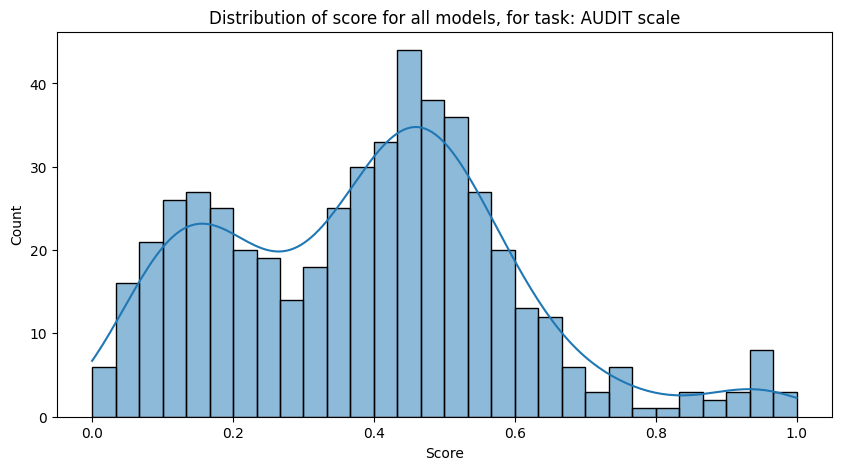

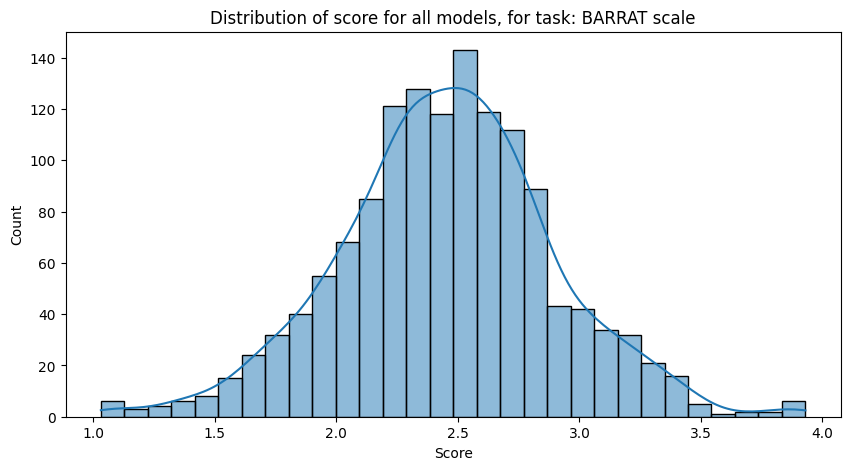

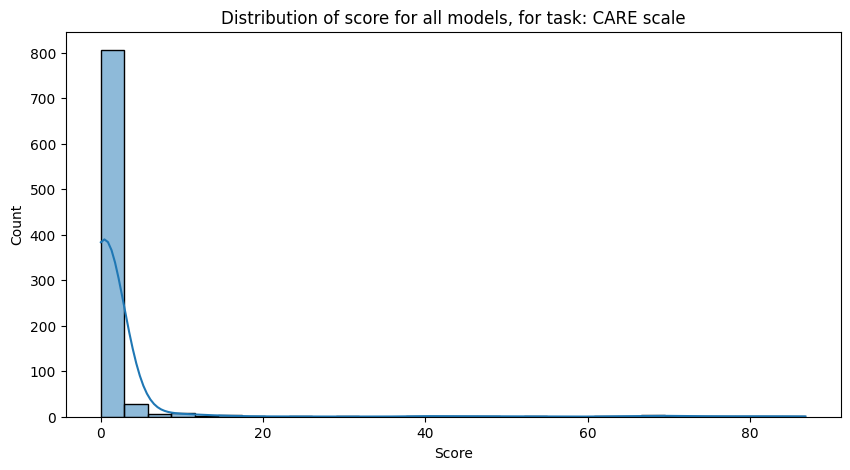

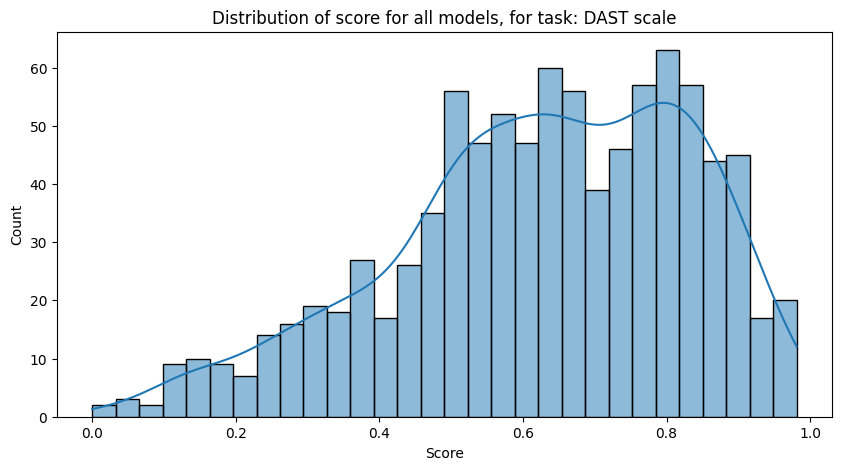

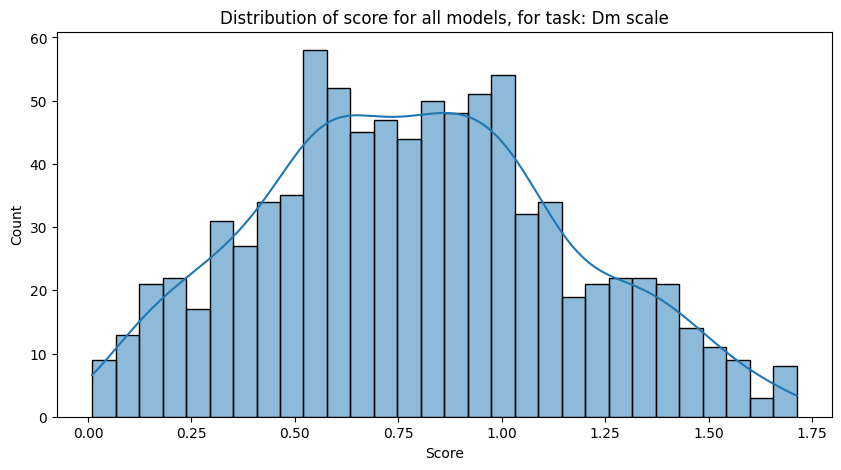

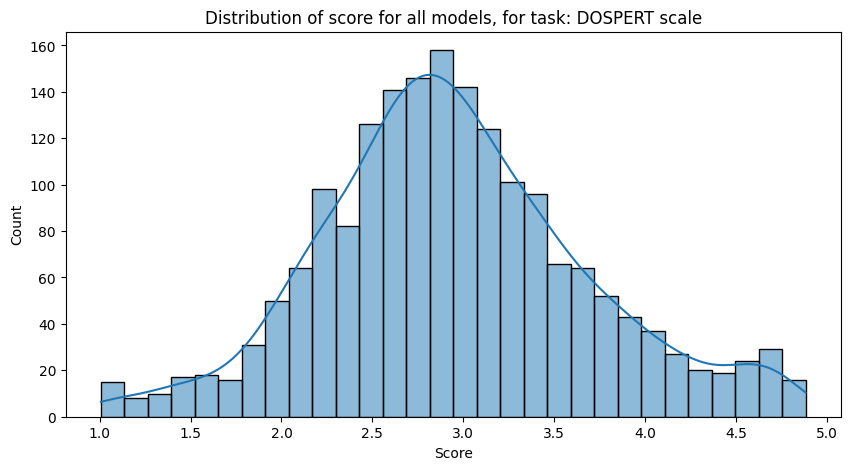

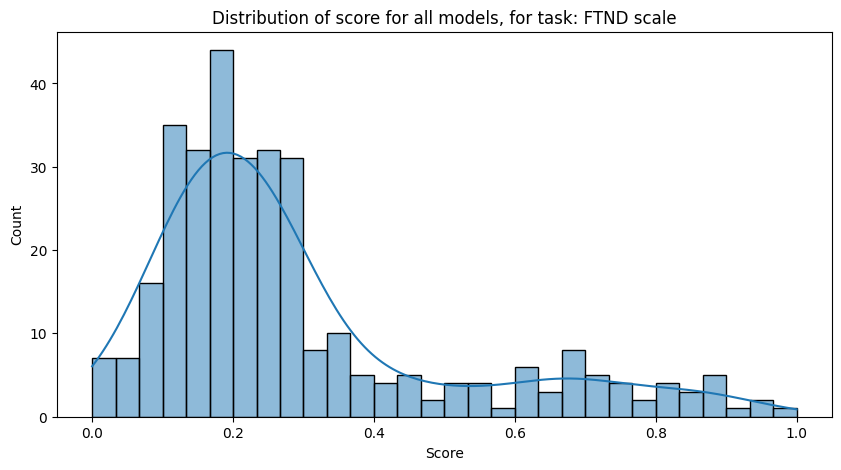

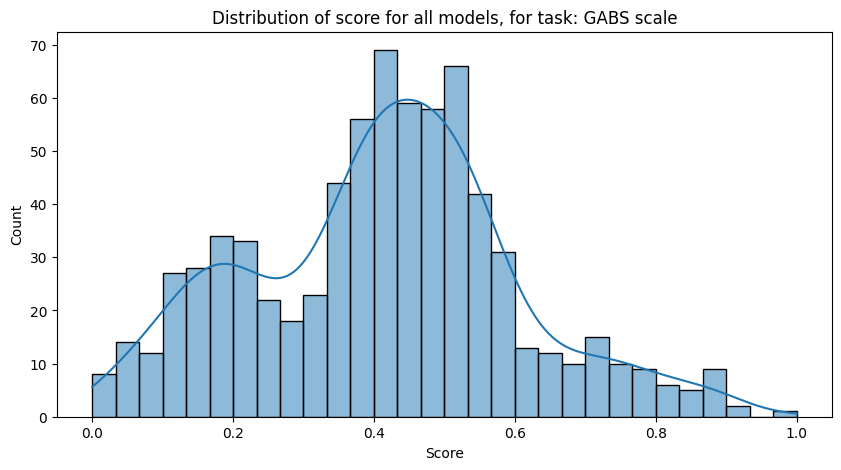

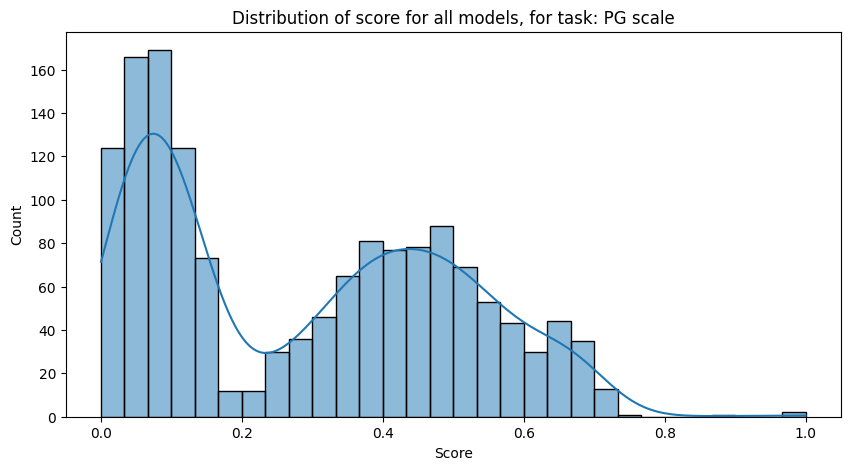

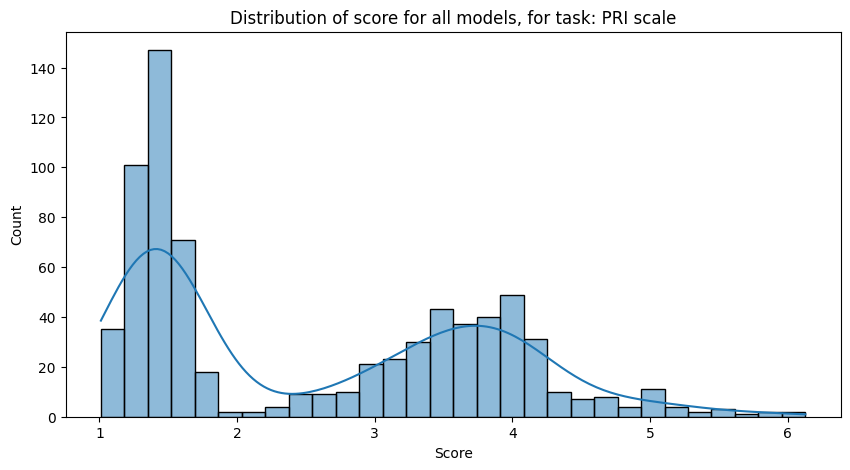

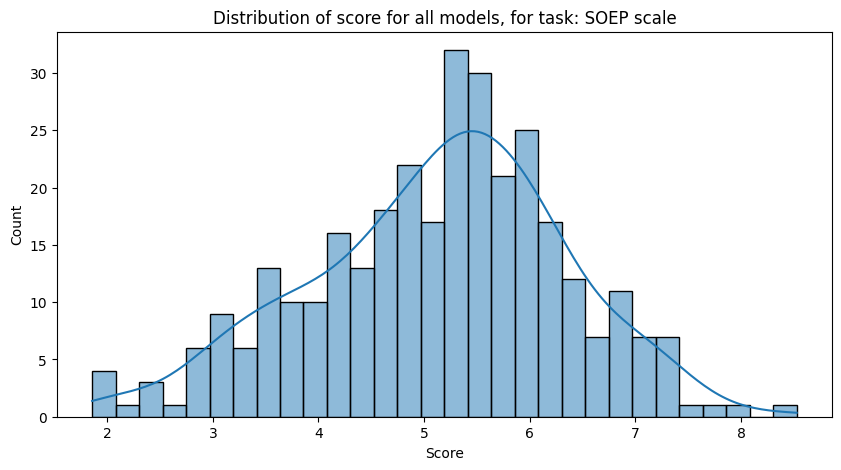

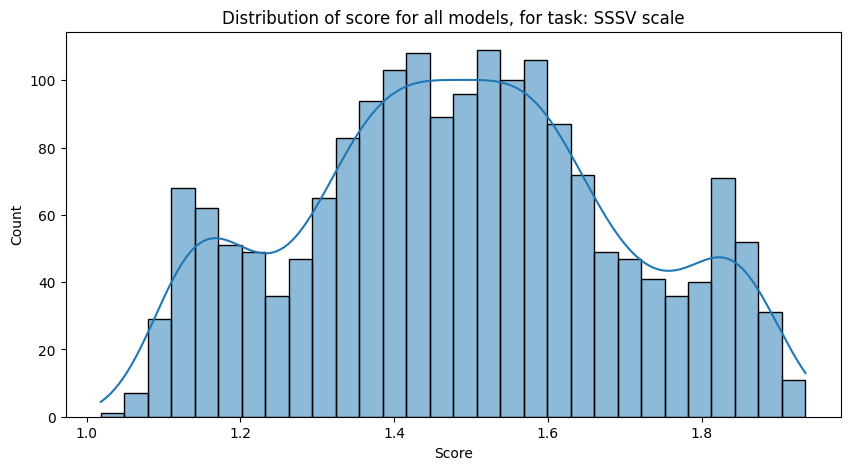

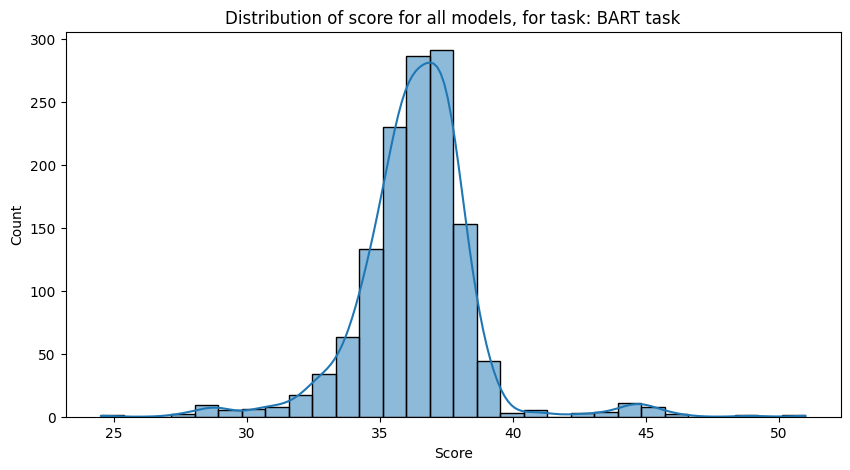

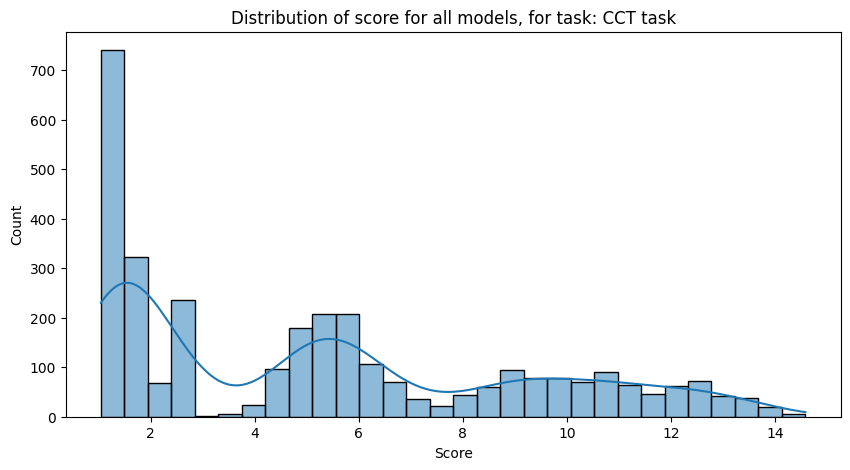

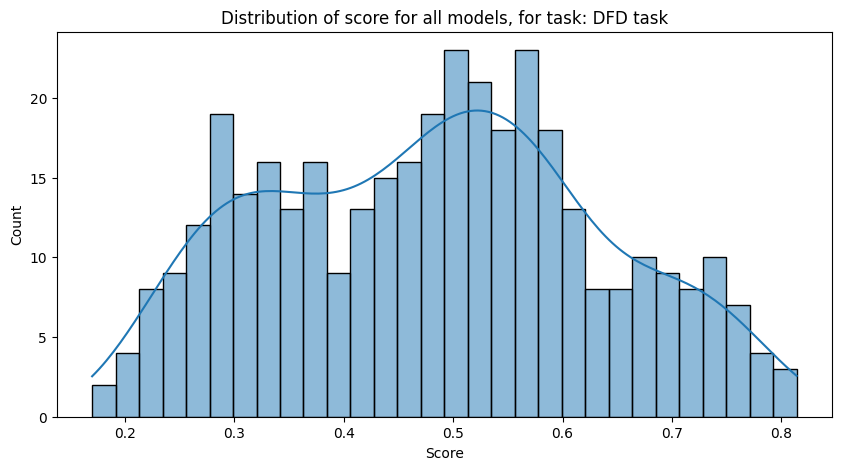

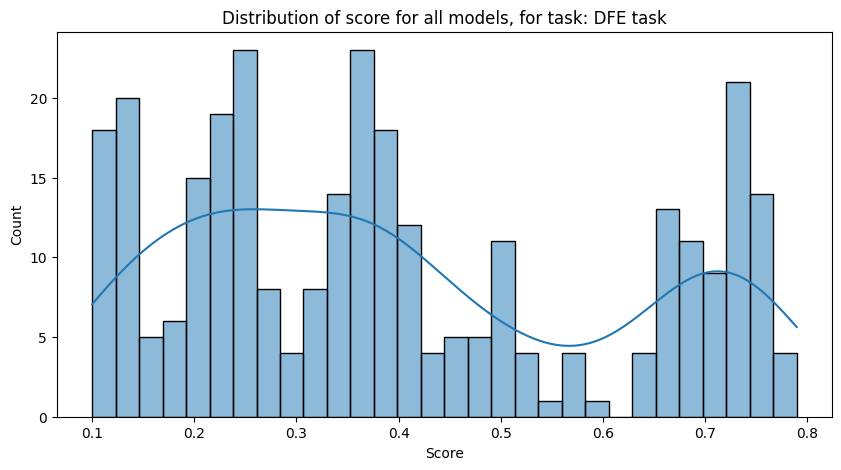

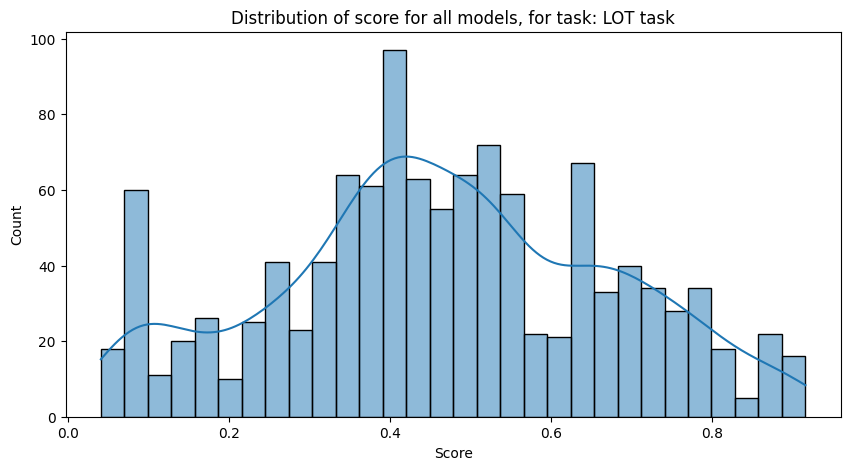

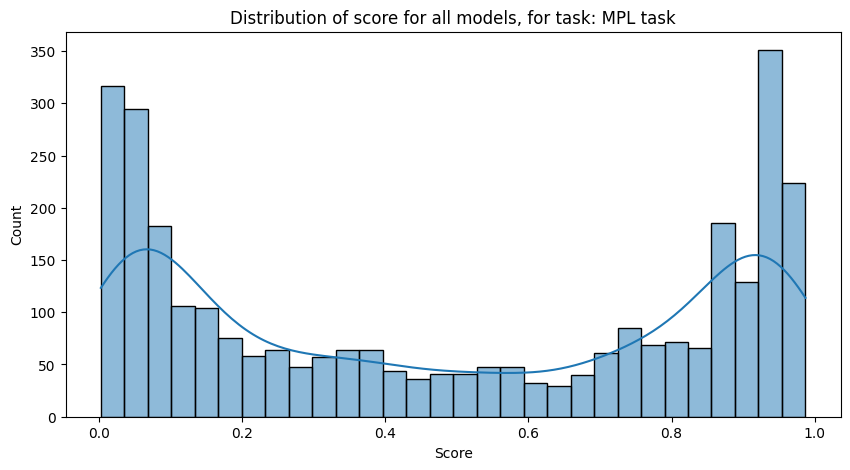

In [16]:
# Visualise distribution (focus on variance) per model of logprobs

#model_names = all_data['model'].unique()
task_names = all_data['experiment'].unique()

#for model_name in model_names:
for task_name in task_names:
    df_plot = all_data[
        #(all_data['model'] == model_name) &
        (all_data['experiment'] == task_name)
    ]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="score", kde=True, bins=30)  
    plt.title(f'Distribution of score for all models, for task: {task_name}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()